# Target Tracking

This tutorial demonstrates how to generate a target tracking profile, and generate Yaw-Pitch-Roll (YPR) angles.

## Setup

In [1]:
import os
import math

import numpy as np

import pandas as pd

import plotly.express as px

from ostk.mathematics.object import RealInterval
from ostk.mathematics.geometry import Angle as MathAngle
from ostk.mathematics.geometry.d3.transformation.rotation import Quaternion
from ostk.mathematics.geometry.d3.transformation.rotation import EulerAngle

from ostk.physics import Environment
from ostk.physics.unit import Length
from ostk.physics.unit import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.time import Time
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Frame
from ostk.physics.coordinate import Transform
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate.frame.provider import Dynamic as DynamicFrameProvider

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.flight import Profile
from ostk.astrodynamics.flight.profile.model import Transform as FlightProfileTransform
from ostk.astrodynamics.access import Generator as AccessGenerator
from ostk.astrodynamics.viewer import Viewer

---

## Computation

Initialize an environment:

In [2]:
environment = Environment.default()
earth = environment.access_celestial_object_with_name("Earth")

Construct an orbit:

In [3]:
orbit = Orbit.sun_synchronous(
    epoch=Instant.date_time(DateTime(2024, 1, 1, 0, 0, 0), Scale.UTC),
    altitude=Length.kilometers(550.0),
    local_time_at_descending_node=Time(14, 30, 0),
    celestial_object=earth,
)

Define an interval of interest:

In [4]:
interval = Interval.closed(
    start_instant=Instant.date_time(DateTime(2024, 1, 1, 0, 0, 0), Scale.UTC),
    end_instant=Instant.date_time(DateTime(2024, 1, 3, 0, 0, 0), Scale.UTC),
)

Define the coordinates of the target to track:

In [5]:
target_lla = LLA(
    latitude=Angle.degrees(0.0),
    longitude=Angle.degrees(0.0),
    altitude=Length.meters(10.0),
)

target_position = Position.meters(
    target_lla.to_cartesian(
        ellipsoid_equatorial_radius=earth.get_equatorial_radius(),
        ellipsoid_flattening=earth.get_flattening(),
    ),
    Frame.ITRF(),
)

Find one access during which the satellite is over the target:

In [6]:
access_generator = AccessGenerator.aer_ranges(
    azimuth_range=RealInterval.closed(0.0, 360.0),
    elevation_range=RealInterval.closed(20.0, 90.0),
    range_range=RealInterval.closed(0.0, 10000e3),
    environment=environment,
)

accesses = access_generator.compute_accesses(
    interval=interval,
    from_trajectory=Trajectory.position(target_position),
    to_trajectory=orbit,
)

access = accesses[0]

Construct a Vehicle Velocity, Local Horizontal (VVLH) frame from the orbit:

In [7]:
vvlh_frame = orbit.get_orbital_frame(Orbit.FrameType.VVLH)

Generate a flight profile:

In [31]:
def calculate_attitude(satellite_state, target_position):
    # Satellite position in GCRF
    satellite_r_GCRF = (
        satellite_state.in_frame(Frame.GCRF()).get_position().get_coordinates()
    )

    # Target position in GCRF
    target_r_GCRF = target_position.in_frame(
        Frame.GCRF(),
        satellite_state.get_instant(),
    ).get_coordinates()

    # Satellite to Target direction vector in GCRF
    u_GCRF = target_r_GCRF - satellite_r_GCRF
    u_GCRF = u_GCRF / np.linalg.norm(u_GCRF)

    # VVLH quaternion in GCRF
    q_VVLH_GCRF = (
        Frame.GCRF()
        .get_transform_to(vvlh_frame, satellite_state.get_instant())
        .get_orientation()
    )

    # Satellite to Target direction vector in VVLH
    u_VVLH = q_VVLH_GCRF * u_GCRF

    # Projection of the Satellite to Target direction vector in VVLH on the XZ plane
    u_VVLH_xz = np.array([u_VVLH[0], 0.0, u_VVLH[2]])
    u_VVLH_xz = u_VVLH_xz / np.linalg.norm(u_VVLH_xz)

    # Satellite attitude quaternion in VVLH
    q_B_VVLH = Quaternion.euler_angle(
        euler_angle=EulerAngle.zyx(
            phi=MathAngle.zero(),
            theta=MathAngle.radians(math.atan2(u_VVLH_xz[0], u_VVLH_xz[2])),
            psi=MathAngle.between(u_VVLH, u_VVLH_xz),
        ),
    )

    q_B_GCRF = (q_B_VVLH * q_VVLH_GCRF).to_normalized()

    return q_B_GCRF


def body_frame_transform_generator(instant):
    state = orbit.get_state_at(instant).in_frame(Frame.GCRF())

    q_B_GCRF = calculate_attitude(
        satellite_state=state,
        target_position=target_position,
    )

    return Transform.active(
        instant,
        -state.get_position().get_coordinates(),
        np.array((0.0, 0.0, 0.0)),
        q_B_GCRF,
        np.array((0.0, 0.0, 0.0)),
    )


profile = Profile(
    model=FlightProfileTransform(
        DynamicFrameProvider(body_frame_transform_generator),
        Frame.GCRF(),
    ),
)

Calculate and plot the Yaw-Pitch-Roll (YPR) angles in the VVLH frame during the access:

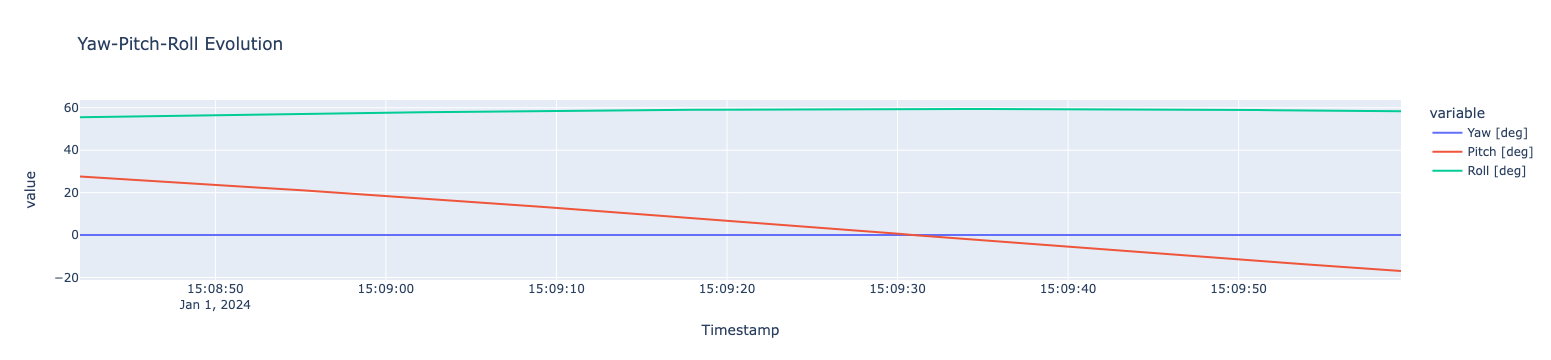

In [55]:
def reduce_angle(angle):
    # Reduce angle to be within the range 0 to 2*pi
    reduced_angle = float(angle.in_radians()) % (2 * math.pi)

    # If angle is negative, add 2*pi to make it positive
    if reduced_angle < 0:
        reduced_angle += 2 * math.pi

    return Angle.radians(reduced_angle)


def calculate_ypr(state):
    state_vvlh = state.in_frame(vvlh_frame)

    q_B_VVLH = state_vvlh.get_attitude()

    ypr = EulerAngle.quaternion(q_B_VVLH, EulerAngle.AxisSequence.ZYX)

    phi = ypr.phi
    theta = ypr.theta
    psi = ypr.psi

    if phi.in_radians() > MathAngle.half_pi().in_radians():
        phi = reduce_angle(phi + MathAngle.pi())
        theta = reduce_angle(MathAngle.pi() - theta)
        psi = reduce_angle(psi + MathAngle.pi())

    if theta.in_radians() > MathAngle.pi().in_radians():
        theta = theta - Angle.two_pi()

    satellite_lla = LLA.cartesian(
        cartesian_coordinates=state.in_frame(Frame.ITRF())
        .get_position()
        .get_coordinates(),
        ellipsoid_equatorial_radius=earth.get_equatorial_radius(),
        ellipsoid_flattening=earth.get_flattening(),
    )

    return (
        state.get_instant().get_date_time(Scale.UTC),
        float(satellite_lla.get_longitude().in_degrees()),
        float(satellite_lla.get_latitude().in_degrees()),
        float(satellite_lla.get_altitude().in_meters()),
        float(phi.in_degrees()),
        float(theta.in_degrees()),
        float(psi.in_degrees()),
    )


yprs = pd.DataFrame(
    data=[
        calculate_ypr(state)
        for state in profile.get_states_at(
            instants=access.get_interval().generate_grid(Duration.seconds(1.0)),
        )
    ],
    columns=[
        "Timestamp",
        "Longitude [deg]",
        "Latitude [deg]",
        "Altitude [m]",
        "Yaw [deg]",
        "Pitch [deg]",
        "Roll [deg]",
    ],
)

yprs.set_index("Timestamp", inplace=True)

px.line(
    yprs[["Yaw [deg]", "Pitch [deg]", "Roll [deg]"]],
    title="Yaw-Pitch-Roll Evolution",
)

Visualize the scene in 3D:

In [56]:
# Get a token from https://cesium.com/learn/ion/cesium-ion-access-tokens/
viewer = Viewer(
    interval=access.get_interval(),
    cesium_token=os.environ.get("CESIUM_TOKEN"),
)

viewer.add_profile(
    profile=profile,
    step=Duration.seconds(10.0),
    show_orbital_track=True,
    cesium_asset_id=1359555,
)

In [57]:
with open("render.html", "w") as f:
    f.write(viewer.render())

---